# Thruster duty cycle

We present an example using the duty-cycle functionality with Q-law. Specifically, we empose the thruster to abide by a duty-cycle, defined by a pair `(ON,OFF)`, where `ON` denotes the maximum duration in time units (`TU`) over which the thruster can be used, and `OFF` denotes the duration required for the thruster to become usable again. 

Note that this functionality does not allocate the use of the thruster optimally, but rather simply imposes a check with the duty-cycle on top of the existing Q-law mechanism. 

We start with our usual imports

In [1]:
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
import time 

import sys
sys.path.append("../../../")    # only required if `pyqlaw` not installed
import pyqlaw

We now define our example going from GTO to GEO. The problem is solved using SMA-MEE. 

In [2]:
# initial and final elements: [a,e,i,RAAN,omega,ta]
LU = 42164.0
GM_EARTH = 398600.44
VU = np.sqrt(GM_EARTH/LU)
TU = LU/VU

rp_gto = 200 + 6378
ra_gto = 35786 + 6378
sma_gto = (rp_gto + ra_gto)/(2*LU)
ecc_gto = (ra_gto - rp_gto)/(ra_gto + rp_gto)
KEP0 = [sma_gto,ecc_gto,np.deg2rad(23),0,0,0]
KEPF = [1,0,np.deg2rad(3),0,0,0]

# initial and final elements with SMA-MEE
oe0 = pyqlaw.kep2mee_with_a(np.array(KEP0))
oeT = pyqlaw.kep2mee_with_a(np.array(KEPF))
woe = [3.0, 1.0, 1.0, 1.0, 1.0]

We define the duty-ratio; here, we consider a thruster that can fire for up to 85\% of a day, after which it needs 15\% of a day to cool down. The tuple `duty_cycle` is the ON and OFF times, in time units. 

In [3]:
# duty cycles
duty_cycle = (0.85*86400/TU, 0.15*86400/TU)
print(f"duty_cycle = {duty_cycle}")

duty_cycle = (5.355362190411142, 0.9450639159549075)


We define the spacecraft parameters, and canonicalize them.

In [4]:
# spacecraft parameters
MU = 1200
tmax_si = 1            # Newtons
isp_si  = 1500         # seconds
mdot_si = tmax_si/(isp_si*9.81)  # kg/s

# non-dimensional quantities
mass0 = 1.0
tmax = tmax_si * (1/MU)*(TU**2/(1e3*LU))
mdot = np.abs(mdot_si) *(TU/MU)
tf_max = 10000.0
t_step = np.deg2rad(5)

We now assemble them into the problem object.

In [5]:
# construct problem
prob = pyqlaw.QLaw(
    rpmin = 6578/LU,
    integrator="rk4", 
    elements_type="mee_with_a",
    verbosity=2,
    print_frequency=3000,
    use_sundman = True,
)

# set problem
prob.set_problem(oe0, oeT, mass0, tmax, mdot, tf_max, t_step, 
    duty_cycle = duty_cycle, woe=woe)
prob.pretty()

Transfer:
  a  : 5.7800e-01 -> 1.0000e+00 (weight: 3.00)
  f  : 7.3009e-01 -> 0.0000e+00 (weight: 1.00)
  g  : 0.0000e+00 -> 0.0000e+00 (weight: 1.00)
  h  : 2.0345e-01 -> 2.6186e-02 (weight: 1.00)
  k  : 0.0000e+00 -> 0.0000e+00 (weight: 1.00)


We can now solve the problem:

In [6]:
# solve
prob.solve(eta_a=0.0, eta_r=0.2)
prob.pretty_results()


 iter   |  time      |  del1       |  del2       |  del3       |  del4       |  del5       |  el6        |
      0 |  1.039e-02 | -4.2196e-01 |  7.3011e-01 |  0.0000e+00 |  1.7726e-01 |  0.0000e+00 |  6.2427e-02 |
   3000 |  1.157e+02 | -3.1978e-01 |  7.2405e-01 |  8.1077e-02 |  1.5857e-01 |  1.3871e-02 |  2.5366e+02 |
   6000 |  2.659e+02 | -2.2516e-01 |  6.8327e-01 |  1.7113e-01 |  1.3319e-01 |  2.9276e-02 |  5.0419e+02 |
   9000 |  4.391e+02 | -1.5501e-01 |  5.9006e-01 |  2.6454e-01 |  9.9072e-02 |  4.1958e-02 |  7.3769e+02 |
  12000 |  6.453e+02 | -9.5636e-02 |  3.7192e-01 |  3.1073e-01 |  4.9651e-02 |  4.1336e-02 |  9.7820e+02 |
Target elements successfully reached!
Exit code : 2
Converge  : True
Final state:
  a  : 9.9825e-01 (error: 1.7453e-03)
  f  : -6.5517e-03 (error: 6.5517e-03)
  g  : 2.4820e-04 (error: 2.4820e-04)
  h  : 2.6189e-02 (error: 2.9896e-06)
  k  : -7.2841e-06 (error: 7.2841e-06)
Transfer time : 868.5673331879086
Final mass    : 0.7317362127486428


and visualize the results

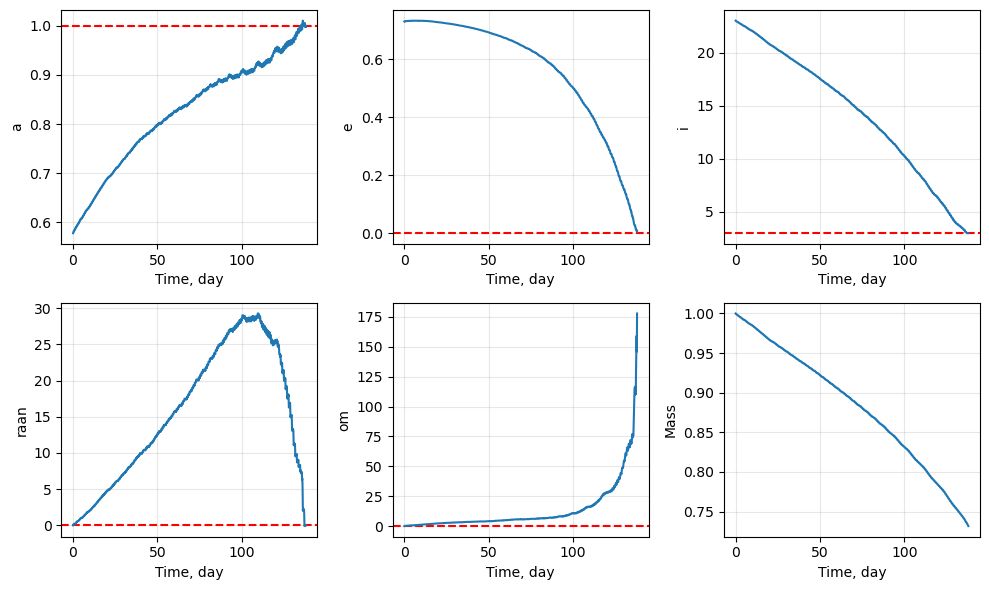

In [7]:
fig1, ax1 = prob.plot_elements_history(to_keplerian=True, TU=TU/86400, time_unit_name="day")
plt.show()

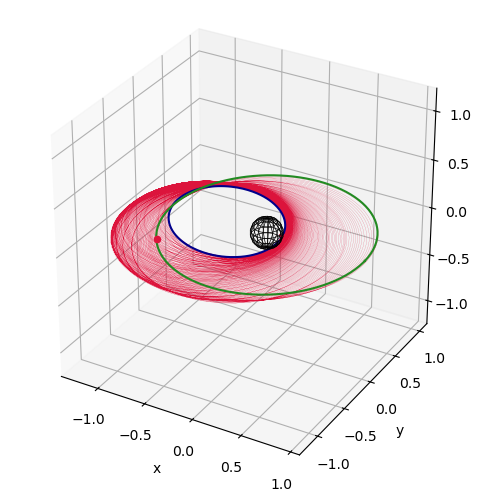

In [8]:
fig2, ax2 = prob.plot_trajectory_3d(sphere_radius=6378/LU, lw=0.1, interpolate=False)
plt.show()

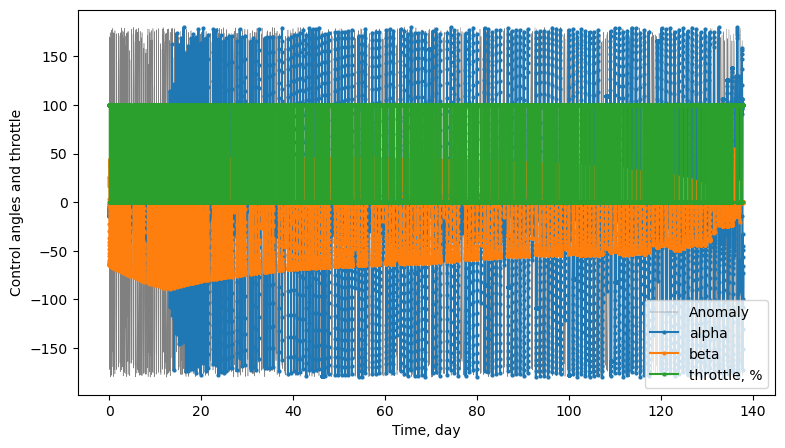

In [9]:
fig3, ax3 = prob.plot_controls(TU=TU/86400, time_unit_name="day")
plt.show()

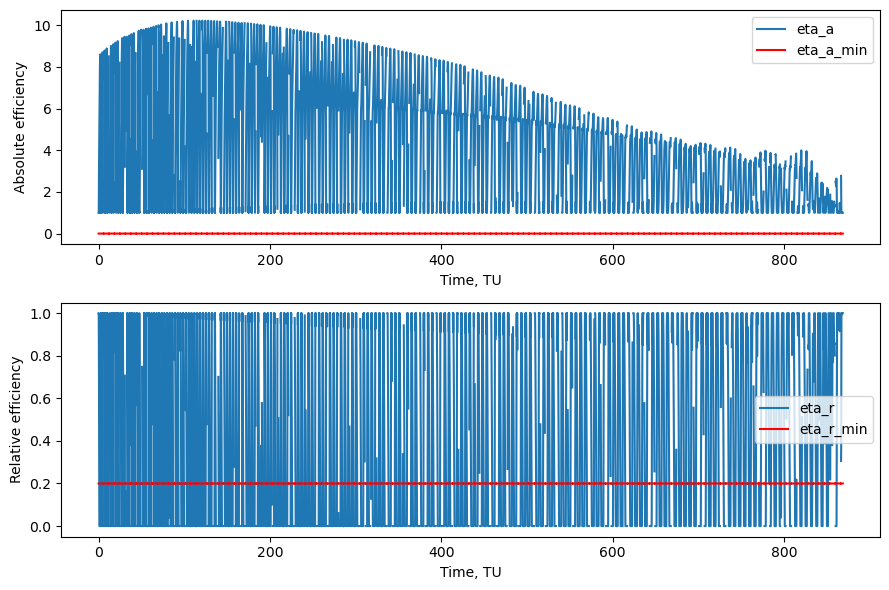

In [10]:
fig4, ax4 = prob.plot_efficiency()
plt.show()